In [6]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from PIL import Image
import os
import torchvision.models as models
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
# ORIGINAL DATA FRPM CIFAR10
def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed = 1,
                           split_ratio=0.1,
                           percent = 1,
                           shuffle=True):
    normalize = transforms.Normalize( mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

    # define transforms
 
    transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])


    # load the dataset
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=transform,
    )
    
    torch.manual_seed(random_seed)
    

    num_samples = int(len(train_dataset) * percent)
    indices = list(range(num_samples))
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
 
    split = int(np.floor(split_ratio * num_samples))
    print(split, num_samples)
    valid_indices = indices[:split]
    train_indices = indices[split:num_samples]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)

    train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=train_sampler, num_workers=2
)

    valid_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64,
        sampler=valid_sampler, num_workers=2
    )

    return (train_loader, valid_loader)


def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True):
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
    torch.manual_seed(1)
    # define transform
    transform = transforms.Compose([        
        transforms.Resize((227,227)),
        transforms.ToTensor(),
        normalize
    ])


    dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )



    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle
    )


    return (data_loader, dataset.classes)



train_loader, valid_loader = get_train_valid_loader(data_dir = '../data', batch_size = 64, random_seed = 1, percent = 0.3)

test_loader, classes = get_test_loader(data_dir = '../data', batch_size = 64, shuffle = False)

dataloaders = {'train':  train_loader,
               'val': valid_loader
               }

Files already downloaded and verified
1500 15000
Files already downloaded and verified


In [14]:
print(len(train_loader.dataset))
print(len(valid_loader.dataset))
print(len(test_loader.dataset))

classes

50000
50000
10000


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [21]:

dataset_sizes = {'train' : 5000, 'val': 500, 'test': 1000}

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

       
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                inputs =  torch.tensor(inputs).to(device)
                labels = torch.tensor(labels).to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))


    model.load_state_dict(best_model_wts)
    return model

In [23]:
model = models.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = True

In [32]:
criterion = nn.CrossEntropyLoss()


optimizer = optim.SGD(model.parameters(), lr=0.001)


step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=5)

Epoch 0/4
----------


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21312\2272575281.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs =  torch.tensor(inputs).to(device)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_21312\2272575281.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


train Loss: 2.3647 Acc: 1.8870
val Loss: 2.0176 Acc: 2.3380

Epoch 1/4
----------


KeyboardInterrupt: 

In [27]:
torch.save(model, '../models/alexnet.pth')





# loaded_model = torch.load('model.pth')

In [28]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(images)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 70.44 %
Accuracy of airplane: 72.9 %
Accuracy of automobile: 74.6 %
Accuracy of bird: 62.9 %
Accuracy of cat: 60.0 %
Accuracy of deer: 73.4 %
Accuracy of dog: 61.1 %
Accuracy of frog: 66.4 %
Accuracy of horse: 67.7 %
Accuracy of ship: 85.7 %
Accuracy of truck: 79.7 %


In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg16

# Load the pre-trained VGG16 model
model = vgg16(pretrained=True)
model.eval()

# Define the transformations for the test dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR100(root='../data', train=False, download=True, transform=transform)

# Create a DataLoader to efficiently load and batch the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(len(classes))]
    n_class_samples = [0 for i in range(len(classes))]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(images)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Files already downloaded and verified


RuntimeError: [enforce fail at ..\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 822083584 bytes.

In [1]:
import cv2
import numpy as np
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from PIL import Image
import os
import matplotlib.pyplot as plt

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


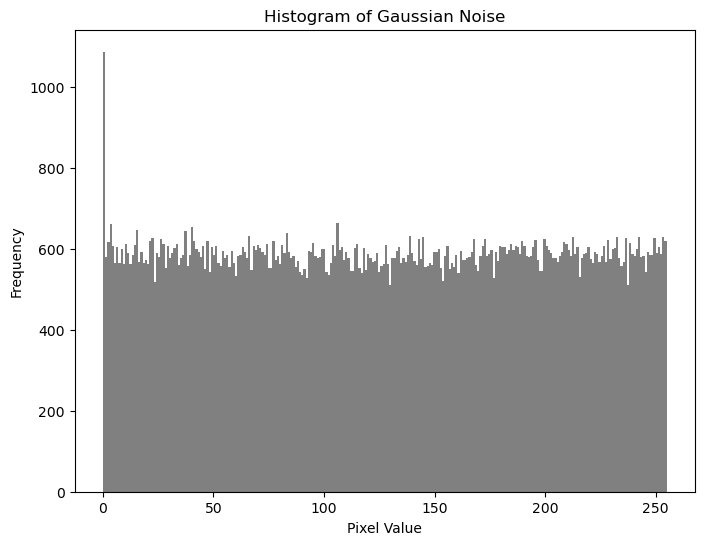

In [2]:



# Example usage
mean=0
std=127
noise_percentage = 0.1  # Replace with the desired noise percentage
img = cv2.imread('../data/test/0028.jpg')
noise = np.zeros(img.shape, np.uint8)
noise = np.random.normal(mean, std, img.shape).astype(np.uint8)

noise_flattened = noise.flatten()

# Plotting the histogram of the Gaussian noise
plt.figure(figsize=(8, 6))
plt.hist(noise_flattened, bins=256, range=(0, 255), color='gray')
plt.title('Histogram of Gaussian Noise')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

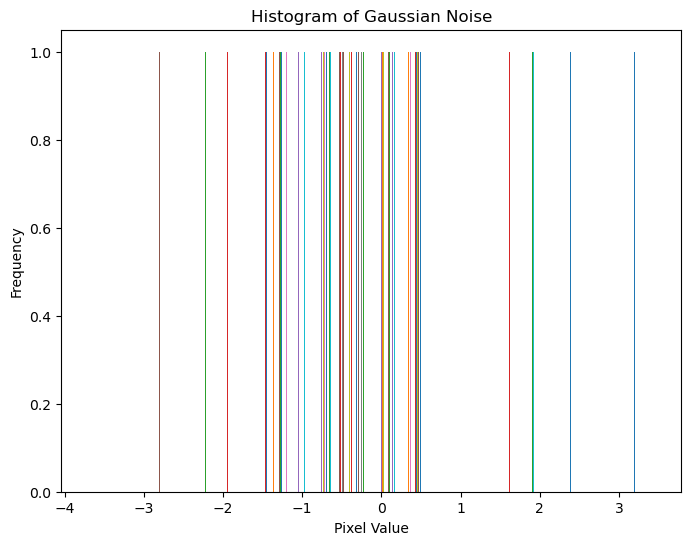

In [5]:
tensor = torch.ones(100, 100)

# Define the mean and standard deviation of the Gaussian noise
mean = 0
std = 1

# Create a tensor of the same size as the original tensor with random noise
noise = torch.tensor(np.random.normal(mean, std, tensor.size()), dtype=torch.float)

noise_flattened = noise.flatten()

# Plotting the histogram of the Gaussian noise
plt.figure(figsize=(8, 6))
plt.hist(noise_flattened)
plt.title('Histogram of Gaussian Noise')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the transformation for MNIST dataset
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # AlexNet input size
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST dataset mean and std
])

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Load pre-trained AlexNet model
alexnet = torchvision.models.alexnet(pretrained=True)


in_features = alexnet._modules['classifier'][-1].in_features
out_features = 10
alexnet._modules['classifier'][-1] = nn.Linear(in_features, out_features, bias=True)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters())

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)

# Training loop
num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    alexnet.train()
    for images, labels in trainloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = alexnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss = train_loss / len(trainloader.dataset)
    train_loss_history.append(train_loss)
    
    # Validation
    val_loss = 0.0
    alexnet.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = alexnet(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
        
    val_loss = val_loss / len(testloader.dataset)
    val_loss_history.append(val_loss)
    
    # Print the training and validation loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

# Plot the training and validation curves
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Curves')
plt.show()


KeyboardInterrupt: 